In [1]:
__author__ = '@Tssp'
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from codvidutils.Autoencoder_Uncertainty_Transformation_main import Transformation_main
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import normalize
from scipy.stats import norm
from codvidutils.imageproc import map_categorical
from PIL import Image
from keras.models import load_model
import pickle

Using TensorFlow backend.


In [2]:
Y_test = []
preds = []
for it in range(10):
    preds += [np.loadtxt('log/preds_XGBr_Uncertainty_{}.txt'.format(it+1), delimiter=',')]

model = 'hdf_files/Uncertainty_AE_Covid_{}.hdf5'.format(it+1)
outputs = Transformation_main('data/train_split_v4.csv', 'data/test_split_v5.csv', model)
Y_test = outputs['Y_test']
X_test = outputs['X_test']
del outputs

You are going to read from: data/train_split_v4.csv and data/test_split_v5.csv
Total number of images: 1524
shape X: 13600 1524,  disease_ID (Y): 13600 1524
Count of classes:  Counter({0: 7966, 2: 5447, 1: 187})
New diseaseID shape:  (9187,)
New X shape:  (9187, 120000)
New Count of classes:  Counter({0: 4500, 2: 4500, 1: 187})
Undersample shapes:
diseaseID_train.shape: (9187,)
X_train.shape: (9187, 120000)
X_train.shape: (9187, 200, 200, 3)
X_test.shape: (1524, 200, 200, 3)
Normal train:  (4500,)
Pneumonia train:  (4500,)
COVID train:  (187,)
*******************************************************
Normal test:  (880,)
Pneumonia test:  (586,)
COVID test:  (58,)
(4675, 180, 180, 3)
(4675,)
X_train.shape:  (13862, 180, 180, 3)
diseaseID_train.shape:  (13862,)
X_test_news.shape:  (1450, 180, 180, 3)
diseaseID_test_news.shape:  (1450,)
X_test.shape:  (2974, 180, 180, 3)
diseaseID_test.shape:  (2974,)
encoder_test.shape (2974, 23, 23, 70)
encoder_train.shape (13862, 23, 23, 70)


In [3]:
predictive_mean = np.mean(preds, axis=0)
predictive_variance = np.var(preds, axis=0)
nocovid = predictive_mean[np.where(Y_test == 0)]
nocovid_variance = predictive_variance[np.where(Y_test == 0)]
covid = predictive_mean[np.where(Y_test == 1)]
covid_variance = predictive_variance[np.where(Y_test == 1)]
print("Mean: {}\nStd: {}".format(predictive_mean, predictive_variance))

Mean: [0.31037878 0.65815872 0.63220662 ... 0.63981575 0.61946719 0.37102058]
Std: [0.00096887 0.00062371 0.00226285 ... 0.00251365 0.00115574 0.00204619]


In [40]:
# Total Error = E_random + E_systematic
E_t = np.sqrt(predictive_variance + 0.205**2)
print("Total error: {}".format(E_t))

Total error: [0.20734964 0.20651563 0.21044678 ... 0.21104181 0.20779975 0.2099314 ]


In [41]:
predictive_mean_up = predictive_mean + E_t
predictive_mean_down = predictive_mean - E_t

# Confusion matrices

In [42]:
def ConfMatrix(Y_test, preds, cut=0.50):
    TP = np.count_nonzero(np.where((Y_test==0) & (preds<cut)))
    FN = np.count_nonzero(np.where((Y_test==1) & (preds>cut)))
    FP = np.count_nonzero(np.where((Y_test==1) & (preds<cut)))
    TN = np.count_nonzero(np.where((Y_test==0) & (preds>cut)))
    out = np.array([[TP, TN],[FP, FN]])
    return out

In [43]:
cm_up = ConfMatrix(Y_test, predictive_mean_up, cut=0.5)
cm = ConfMatrix(Y_test, predictive_mean, cut=0.5)
print('{} of {} no COVID-19 ({:2.4}%)'.format(cm[0,0], cm[0,0] + cm[0,1], 100*cm[0,0]/(cm[0,0]+cm[0,1])))
print('{} of {} COVID-19 ({:2.3}%)'.format(cm[1,1], cm[1,1] + cm[1,0], 100*cm[1,1]/(cm[1,1]+cm[1,0])))
print("Means + E_t:\n{}".format(cm))
cm_down = ConfMatrix(Y_test, predictive_mean_down, cut=0.5)
# Distance taking into account the error interval
dist_up = np.absolute(cm_up - cm)
dist_down = np.absolute(cm - cm_down)
print("Upper distance:\n{}".format(dist_up))
print("Lower distance:\n{}".format(dist_down))

1364 of 1466 no COVID-19 (93.04%)
759 of 1507 COVID-19 (50.4%)
Means + E_t:
[[1364  102]
 [ 748  759]]
Upper distance:
[[518 518]
 [633 633]]
Lower distance:
[[102 102]
 [710 710]]


# Histograms

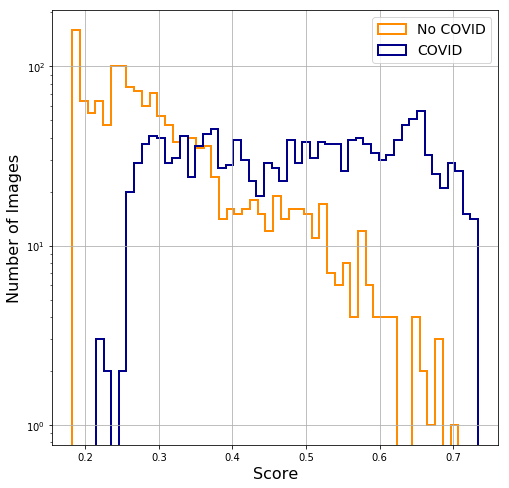

In [44]:
fig, ax = plt.subplots(figsize=(8,8))
ax.hist(nocovid, 50, histtype='step', lw=2, color='darkorange', label='No COVID')
ax.hist(covid, 50, histtype='step', lw=2, color='darkblue', label='COVID')
plt.grid()
ax.set_ylabel('Number of Images', fontsize=16)
ax.set_xlabel('Score', fontsize=16)
plt.legend( loc='upper right', fontsize=14)
plt.yscale("log")
fig.savefig('Figures/histogram_Uncertainty_XGBr.eps', dpi=200)

## Curva ROC

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, predictive_mean)
fpr_U, tpr_U, thr = roc_curve(Y_test, predictive_mean_up)
fpr_L, tpr_L, thr = roc_curve(Y_test, predictive_mean_down)
roc_auc = auc(fpr, tpr)
roc_auc_U = auc(fpr_U, tpr_U)
roc_auc_L = auc(fpr_L, tpr_L)

In [ ]:
fig3, ax3 =plt.subplots(figsize=(8,8))
ax3.plot(fpr_U, tpr_U, color='blue',lw=2, label='ROC-curve Upper (AUC = %0.3f)' % (roc_auc_U), alpha=0.7)
ax3.plot(fpr_L, tpr_L, color='blue',lw=2, label='ROC-curve Lower (AUC = %0.3f)' % (roc_auc_L), alpha=0.7)
ax3.plot(fpr, tpr, color='k', label='ROC-curve (AUC = %0.3f)' % (roc_auc))
ax3.set_ylabel('True Positie Rate (TPR)', fontsize=16)
ax3.set_xlabel('False Positive Rate (FPR)', fontsize=16)
plt.grid()
plt.legend(loc="lower right", fontsize=14)
fig3.savefig('Figures/ROC')
plt.show()


# Histogram with Bernoulli integration

In [30]:
def integration(data, var, nbins):
    g = np.linspace(0, 1, nbins+1)
    sP = (len(data), nbins)
    output = np.zeros(sP)
    for i in range(len(data)):
        for j in range(nbins):
            output[i,j] = (norm.cdf(g[j+1], loc=data[i], scale=var[i]) - norm.cdf(g[j], loc=data[i], scale=var[i]))
    return g, output

In [31]:
g, P_covid = integration(covid, covid_variance, 30)
_, P_nocovid = integration(nocovid, nocovid_variance, 30)

In [32]:
counts_covid= np.sum(P_covid, axis=0)
counts_nocovid= np.sum(P_nocovid, axis=0)
variance_covid = np.sum(np.multiply(P_covid, (1 - P_covid)), axis=0)
variance_nocovid = np.sum(np.multiply(P_nocovid, (1 - P_nocovid)), axis=0)

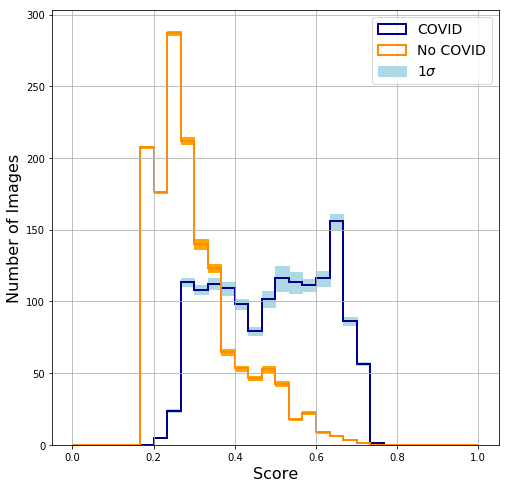

In [33]:
fig4, ax4 = plt.subplots(figsize = (8,8))
ax4.hist(g[:-1], g, weights=counts_covid, histtype='step', color='darkblue', lw=2)
ax4.hist(g[:-1], g, weights=counts_nocovid, histtype='step', color='darkorange', lw=2)
for i in range(counts_covid.shape[0]):
    ax4.fill_between(g[i:i+2], counts_covid[i] - variance_covid[i], counts_covid[i] + variance_covid[i], color='lightblue')
    ax4.fill_between(g[i:i+2], counts_nocovid[i] - variance_nocovid[i], counts_nocovid[i] + variance_nocovid[i], 
                     color='orange')
ax4.set_ylabel("Number of Images", fontsize=16)
ax4.set_xlabel("Score", fontsize=16)
plt.legend(['COVID', 'No COVID', '$1\sigma$'], fontsize=14)
plt.grid()
fig4.savefig('Figures/histogram_Uncertainty_Integration_XGBr.eps', dpi=200)

# Final prediction with uncertainties

In [34]:
best_pred_loc = np.where(predictive_mean == np.max(predictive_mean))[0][0]

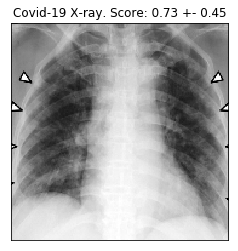

In [39]:
fig, ax = plt.subplots()
ax.imshow(X_test[best_pred_loc])
ax.set_title('Covid-19 X-ray. Score: {:.2} +- {:.2}'.format(predictive_mean[best_pred_loc], 
                                                                  E_t[best_pred_loc]))
ax.set_xticks(())
ax.set_yticks(())
fig.savefig('Figures/Best_prediction_Covid.eps', dpi=200)